In [158]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

tqdm.pandas()

In [243]:
raw_data = pd.read_csv("../data/paragraphs.csv")

In [244]:
raw_data.shape

(1701, 1)

In [99]:
raw_data[raw_data.duplicated()]

,text
19,Reading Russia and the Soviet Union in the twentieth century
24,Reading Russia and the Soviet Union in the twentieth century
30,Reading Russia and the Soviet Union in the twentieth century
35,Reading Russia and the Soviet Union in the twentieth century
40,Reading Russia and the Soviet Union in the twentieth century
...,...
1677,"P1: GDZ\n 0521834325c12.xml CY465-Chickering 0 521 83432 5 September 8, 2004 2:17"
1681,"P1: GDZ\n 0521834325c12.xml CY465-Chickering 0 521 83432 5 September 8, 2004 2:17"
1688,"P1: GDZ\n 0521834325c12.xml CY465-Chickering 0 521 83432 5 September 8, 2004 2:17"
1693,"P1: GDZ\n 0521834325c12.xml CY465-Chickering 0 521 83432 5 September 8, 2004 2:17"


In [100]:
data = raw_data.drop_duplicates()

In [101]:
data.reset_index(drop=True, inplace=True)

In [102]:
type(data)

pandas.core.frame.DataFrame

In [103]:
data.isna().sum()

text    0
dtype: int64

In [104]:
data.text = data.text.apply(lambda x: x.replace("\n", " ").lower())

/var/folders/64/q9vthv094_591jd1jlz91_x00000gn/T/ipykernel_42081/3367912696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.text = data.text.apply(lambda x: x.replace("\n", " ").lower())


In [105]:
tfidf = TfidfVectorizer()

In [106]:
tfidf.fit(data.text)

TfidfVectorizer()

In [107]:
data_vec = tfidf.transform(data.text)

In [108]:
pca_raw = PCA(n_components=2)

In [109]:
data_vec2d = pca_raw.fit_transform(data_vec.toarray())

In [110]:
data_vec2d

array([[-0.17482974, -0.17490296],
       [ 0.02648624, -0.04006863],
       [-0.28393291, -0.10525227],
       ...,
       [-0.1539857 , -0.08659025],
       [-0.18583417, -0.1856176 ],
       [ 0.15524182, -0.13064664]])

In [111]:
data_vec2d = pd.DataFrame(data_vec2d, columns=["x", "y"])

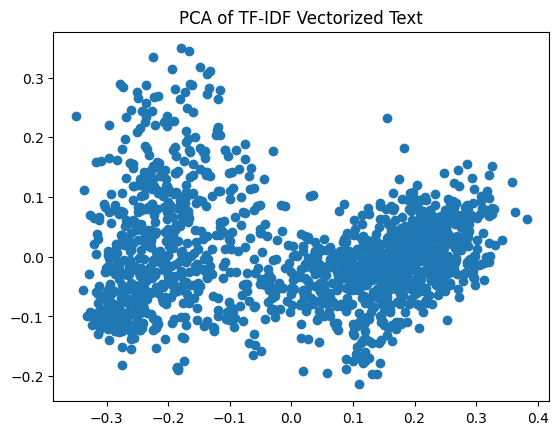

In [112]:
plt.scatter(data_vec2d.x, data_vec2d.y)
plt.title("PCA of TF-IDF Vectorized Text")
plt.show()

In [113]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
labels = dbscan.fit_predict(data_vec2d)
data_vec2d["cluster"] = labels

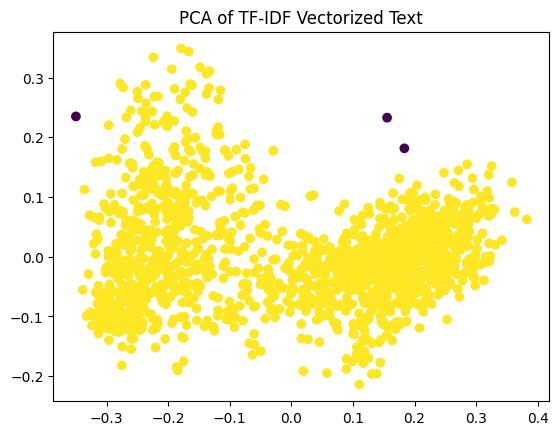

In [114]:
plt.scatter(data_vec2d.x, data_vec2d.y, c=data_vec2d.cluster)
plt.title("PCA of TF-IDF Vectorized Text")
plt.show()

In [115]:
data_pca_and_dbscan = pd.concat([data, data_vec2d], axis=1)

In [116]:
data_pca_and_dbscan.loc[data_pca_and_dbscan.cluster != 0][["text"]].to_csv("../data/cluster_0.csv", index=False)

In [117]:
inertia = []
k_range = range(1, 11)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_vec)
    inertia.append(kmeans.inertia_)


  0%|          | 0/10 [00:00<?, ?it/s]

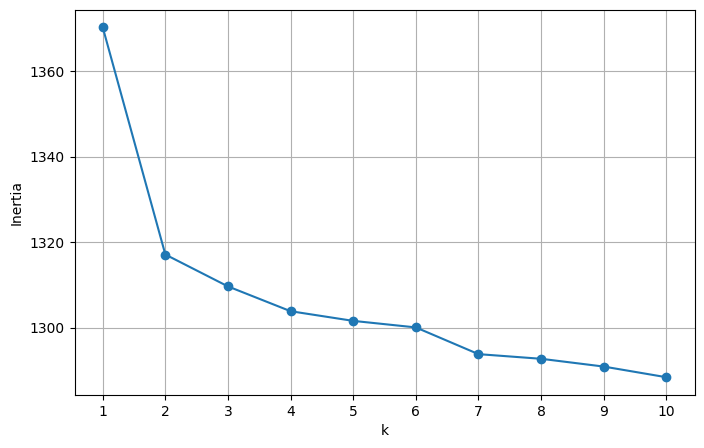

In [118]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks(k_range)
plt.grid()
plt.show()


In [119]:
kmean = KMeans(n_clusters=10, random_state=42)
kmean.fit(data_vec)

KMeans(n_clusters=10, random_state=42)

In [120]:
data_pca_and_dbscan.cluster = kmean.predict(data_vec)

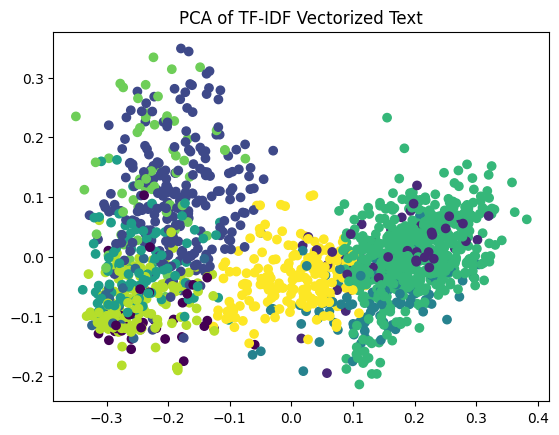

In [121]:
plt.scatter(data_pca_and_dbscan.x, data_pca_and_dbscan.y, c=data_pca_and_dbscan.cluster)
plt.title("PCA of TF-IDF Vectorized Text")
plt.show()

In [122]:
data_pca_and_dbscan.sort_values(by="cluster", inplace=True)
data_pca_and_dbscan.to_csv("../data/clustered_paragraphs.csv", index=False)

In [123]:
data_pca_and_dbscan.cluster.value_counts()

6    571
2    237
9    193
8    149
5    105
4     94
1     59
7     58
0     53
3     17
Name: cluster, dtype: int64

In [124]:
data_pca_and_dbscan[data_pca_and_dbscan.cluster == 3].to_csv("../data/cluster_3.csv")

In [144]:
cluster_0 = data_pca_and_dbscan[data_pca_and_dbscan.cluster == 0].to_csv("../data/cluster_0.csv")

In [126]:
data_pca_and_dbscan[data_pca_and_dbscan.cluster == 7].to_csv("../data/cluster_7.csv")

In [139]:
data_pca_and_dbscan[data_pca_and_dbscan.cluster == 2].to_csv("../data/cluster_2.csv")

In [142]:
data_pca_and_dbscan[data_pca_and_dbscan.cluster == 8].to_csv("../data/cluster_8.csv")

In [211]:
fake_indexes = []

In [212]:
for i in [0, 2, 3, 7, 8]:
    _cluster = pd.read_csv(f"../data/cluster_{i}.csv")
    fake_indexes.extend(_cluster["Unnamed: 0"].tolist())

In [196]:
mask = ~raw_data.index.isin(fake_indexes)
clean_data = raw_data[mask]
clean_data.to_csv("../data/paragraphs_without_authors.csv", index=False)

In [197]:
from gensim.models import Word2Vec

In [198]:
w2v = Word2Vec(
    sentences=data.text.apply(lambda x: x.split(" ")).tolist(),
    vector_size=200,
    window=5,
    min_count=1,
)

In [199]:
w2v.wv.most_similar("author", topn=10)

[('russia’s', 0.9984307885169983),
 ('president', 0.9982277750968933),
 ('rate', 0.9982108473777771),
 ('practices', 0.9982019662857056),
 ('art', 0.9981990456581116),
 ('civilian', 0.9981293678283691),
 ('white', 0.9980807900428772),
 ('modern', 0.9980712532997131),
 ('tsarist', 0.9980520606040955),
 ('food', 0.9980519413948059)]

In [200]:
import numpy as np

def sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [201]:
vectors = clean_data.copy()
vectors["vector"] = vectors.text.progress_apply(lambda x: sentence_vector(x, w2v))

  0%|          | 0/1192 [00:00<?, ?it/s]

In [202]:
w2v_pca = PCA(n_components=2)
w2v_pca.fit(vectors["vector"].tolist())

PCA(n_components=2)

In [203]:
w2v_2d = w2v_pca.transform(vectors["vector"].tolist())

In [204]:
w2v_2d = pd.DataFrame(w2v_2d, columns=["x", "y"])
w2v_2d["text"] = vectors.text.reset_index(drop=True)

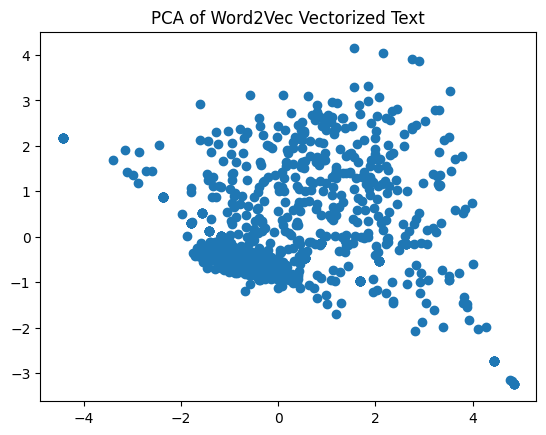

In [205]:
plt.scatter(w2v_2d.x, w2v_2d.y)
plt.title("PCA of Word2Vec Vectorized Text")
plt.show()

In [206]:
dbscan = DBSCAN(eps=0.05)
labels = dbscan.fit_predict(vectors["vector"].tolist())
w2v_2d["cluster"] = labels

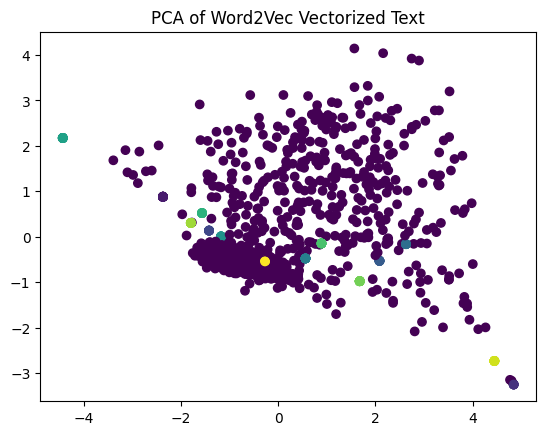

In [207]:
plt.scatter(w2v_2d.x, w2v_2d.y, c=w2v_2d.cluster)
plt.title("PCA of Word2Vec Vectorized Text")
plt.show()

In [208]:
w2v_2d[w2v_2d.cluster != -1]

,x,y,text,cluster
11,-2.370931,0.880789,Reading Russia and the Soviet Union in the twentieth century,0
14,-2.370931,0.880789,Reading Russia and the Soviet Union in the twentieth century,0
17,-2.370931,0.880789,Reading Russia and the Soviet Union in the twentieth century,0
22,-2.370931,0.880789,Reading Russia and the Soviet Union in the twentieth century,0
32,-2.370931,0.880789,Reading Russia and the Soviet Union in the twentieth century,0
...,...,...,...,...
1179,4.449787,-2.734039,"P1: GDZ\n 0521834325c12.xml CY465-Chickering 0 521 83432 5 September 8, 2004 2:17",12
1180,-0.272851,-0.545093,"Women in the Soviet War Effort, 1941–1945 241",13
1184,4.449787,-2.734039,"P1: GDZ\n 0521834325c12.xml CY465-Chickering 0 521 83432 5 September 8, 2004 2:17",12
1189,4.449787,-2.734039,"P1: GDZ\n 0521834325c12.xml CY465-Chickering 0 521 83432 5 September 8, 2004 2:17",12


In [210]:
indexes = w2v_2d[w2v_2d.cluster != -1].index
mask = ~clean_data.index.isin(indexes)
clean_data[mask].to_csv("../data/paragraphs_without_authors_w2v.csv", index=False)

In [214]:
# --------

In [245]:
raw_data2 = pd.read_csv("../data/paragraphs_without_authors_w2v.csv", encoding="utf-8", on_bad_lines="skip")

In [248]:
raw_data2.text = raw_data2.text.apply(lambda x: x.replace("\n", " "))

In [251]:
raw_data2 = raw_data2.drop_duplicates()

In [253]:
raw_data2.to_csv("../data/raw_data2.csv", index=False)